In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
from distgen.dist import Uniform
from distgen.dist import SuperGaussian
from distgen.dist import Norm
from distgen.physical_constants import unit_registry

from matplotlib import pyplot as plt

import numpy as np

# Metrics for comparing different distributions
---
In some cases, it is desired to target a particular distribution shape in an optimization.  To facilitate this the following two metrics are implemented:

## Kullback-Leibler (Relative Entropy)
Defined as:
$D_{KL}(P|Q) = \int_{-\infty}^{\infty}p(x)\ln{\left(\frac{p(x)}{q(x)}\right)} dx$

Note that this is not well defined in regions where the PDF $q(x)=0$.  This causes trouble for distributions like a uniform distribution.  For this, its suggested to use a SuperGaussian to approximate the uniform dist (see below).

https://en.wikipedia.org/wiki/Kullback–Leibler_divergence

In [3]:
L = 2*unit_registry('ps')
avg_t_sg = 0*unit_registry('ps')
sigma_t_sg = L/np.sqrt(12)

In [4]:
sg = SuperGaussian('t', avg_t=avg_t_sg, sigma_t=sigma_t_sg, p=12)

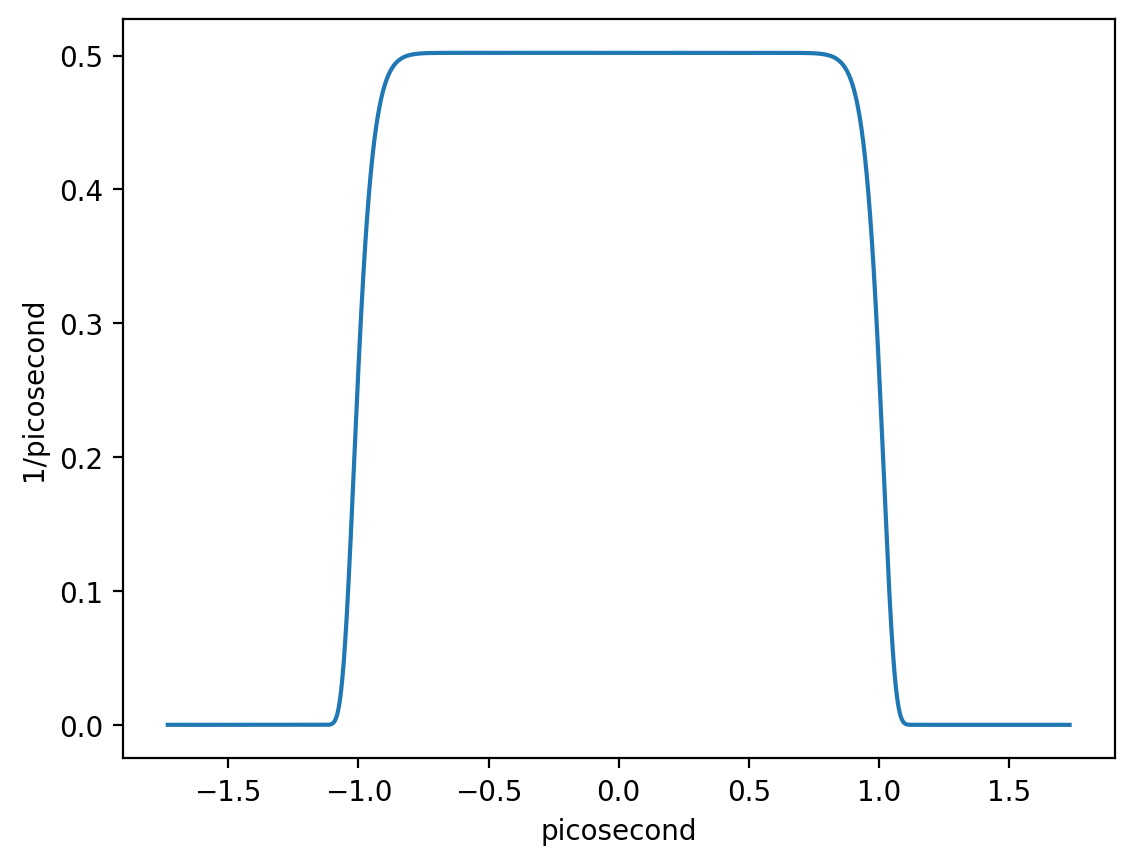

In [5]:
tsg, Psg = sg.get_x_pts(), sg.pdf()
plt.plot(tsg, Psg);

In [6]:
norm = Norm('t', avg_t=avg_t_sg, sigma_t=sigma_t_sg)

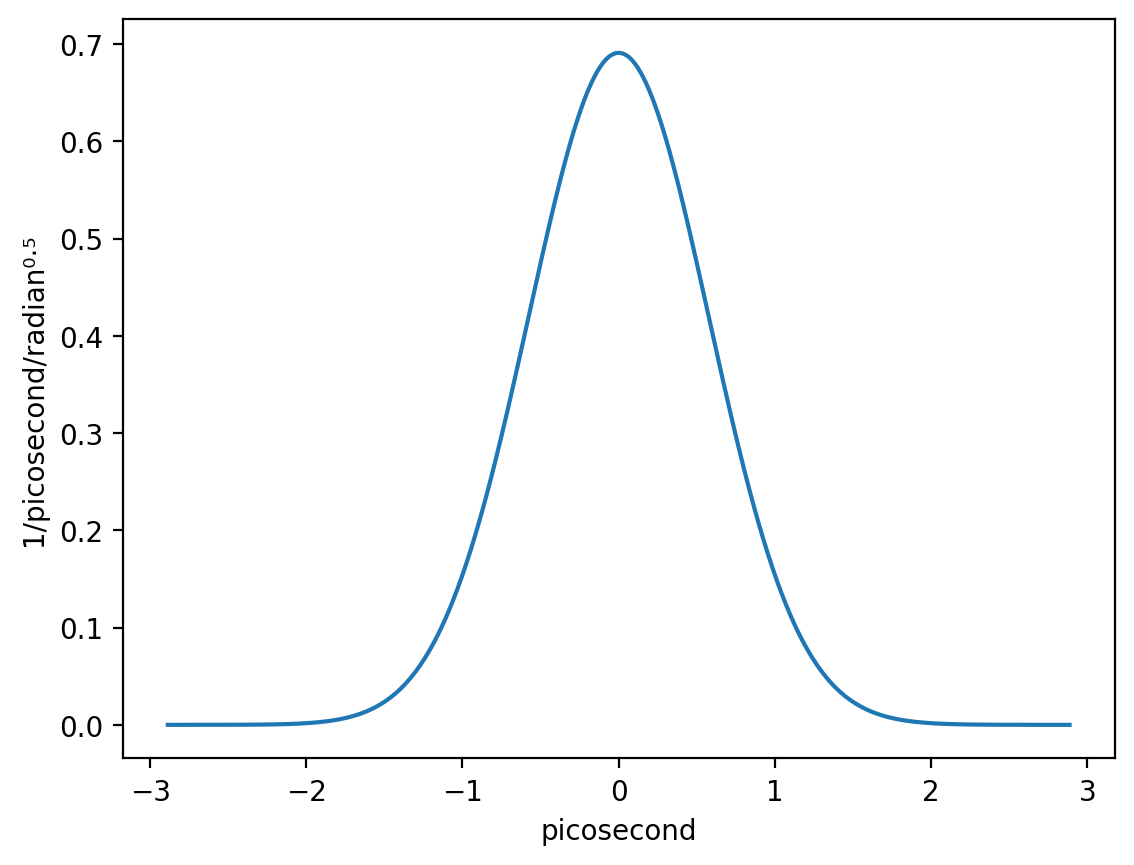

In [7]:
tn, Pn = norm.get_x_pts(), norm.pdf()
plt.plot(tn, Pn);

In [8]:
from distgen.metrics import kullback_liebler_div

In [9]:
kullback_liebler_div(tn, Pn, tsg, Psg, as_float=False)

4.301370109274345 <Unit('dimensionless')>

The functions work with raw NumPy arrays, and support both float output or Pint Quantity outputs:

In [10]:
kullback_liebler_div(tn.magnitude, Pn.magnitude, tsg.magnitude, Psg.magnitude, as_float=True)

4.301370109274345

In addition to the Kullback Liebler Divergence, the residual squared between two distributions is implemented:


In [11]:
from distgen.metrics import res2

In [12]:
res2(tn, Pn, tsg, Psg, as_float=False)

0.05844190183816797 <Unit('1 / picosecond')>

In [13]:
res2(tn.magnitude, Pn.magnitude, tsg.magnitude, Psg.magnitude, as_float=True)

0.05844190183816797